# Exploration of data for RNN implementation

In [1]:
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from src.RNN import RnnTrainer, VanillaRNN, LSTMModel, GRUModel
from src.Training_utils import TrainingHelper
import torch.nn as nn
import numpy as np


In [155]:
total_set = pd.concat([pd.read_csv('Google_Stock_Price_Train.csv',sep=',')[['Open','High','Low']],pd.read_csv('Google_Stock_Price_Test.csv',sep=',')[['Open','High','Low']]])
total_set=total_set.reset_index()[['Open','High','Low']]

# train_set = pd.read_csv('Google_Stock_Price_Train.csv',sep=',')[['Open','High','Low']]
# test_set = pd.concat([train_set[len(train_set)-100:len(train_set)],pd.read_csv('Google_Stock_Price_Test.csv',sep=',')[['Open','High','Low']]])
# val_set = train_set[len(train_set)-220:len(train_set)-100]
# train_set = train_set[0:len(train_set)-120]


n = len(total_set)
train_set = total_set[0:n-100]
val_set = total_set[n-100:n-50]
test_set = total_set[n-50:n]


n_history = 3

train_set_with_low = pd.read_csv('Google_Stock_Price_Train.csv',sep=',')
train_set_with_low.Close = train_set_with_low.Close.str.replace(',','').astype(float)


sc = MinMaxScaler(feature_range = (0, 1))
single_scaler = MinMaxScaler(feature_range = (0,1)).fit(pd.concat([train_set,val_set,test_set])[['Open']])
sc.fit(pd.concat([train_set,val_set,test_set]))


train_set_scaled = train_set.copy()
train_set_scaled[train_set_scaled.columns]=sc.transform(train_set)
val_set_scaled = val_set.copy()
val_set_scaled[val_set_scaled.columns]=sc.transform(val_set_scaled)
# test_set_scaled = pd.concat([val_set[len(val_set)-n_history:len(val_set)],test_set])
test_set_scaled = test_set.copy()
test_set_scaled[test_set_scaled.columns]=sc.transform(test_set_scaled)

<AxesSubplot:>

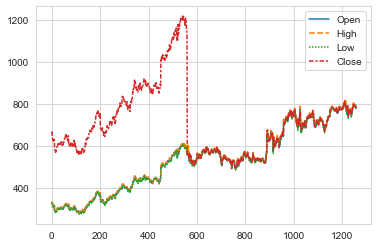

In [156]:



sns.set_style("whitegrid")
fig,ax=plt.subplots()

sns.lineplot(data=train_set_with_low,ax=ax)


<AxesSubplot:>

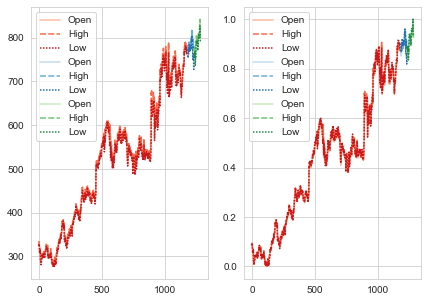

In [157]:

sns.set_style("whitegrid")
fig,ax=plt.subplots(1,2,figsize=(7,5))

sns.lineplot(data=train_set,ax=ax[0],palette='Reds')
sns.lineplot(data=val_set,ax=ax[0],palette='Blues')
sns.lineplot(data=test_set,ax=ax[0],palette='Greens')


sns.lineplot(data=train_set_scaled,ax=ax[1],palette='Reds')
sns.lineplot(data=val_set_scaled,ax=ax[1],palette='Blues')
sns.lineplot(data=test_set_scaled,ax=ax[1],palette='Greens')




## Training a vanilla RNN model on the first training set

In [174]:
import torch.optim as optim

# This works nicely
n_history = 3
input_dim = n_history
hidden_dim = 3
layer_dim = 1
output_dim = 1
batch_size = 6
dropout = 0
n_epochs = 200
learning_rate = 1e-3
weight_decay = 1e-6


# n_history = 4
# input_dim = n_history
# hidden_dim = 3
# layer_dim = 1
# output_dim = 1
# batch_size = 64
# dropout = 0.5
# n_epochs = 200
# learning_rate = 1e-3
# weight_decay = 1e-6


model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'num_layers' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

def get_model(model, model_params):
    models = {
        "rnn": VanillaRNN,
        "lstm": LSTMModel,
        "gru": GRUModel
    }
    return models.get(model.lower())(**model_params)


Training_Helper = TrainingHelper(n_history,train_set_scaled,val_set_scaled,test_set_scaled)
train_loader,val_loader,test_loader,test_loader_one = Training_Helper.generate_dataloader(batch_size)
X_train,y_train = Training_Helper.generate_tensors()['train']
X_val,y_val = Training_Helper.generate_tensors()['val']
X_test,y_test = Training_Helper.generate_tensors()['test']


  0%|          | 0/200 [00:00<?, ?it/s]C:\Users\jngt\anaconda3\envs\UoA-DL\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
[200/200] Training loss: 0.0005	 Validation loss: 0.0004: 100%|██████████| 200/200 [00:52<00:00,  3.78it/s]


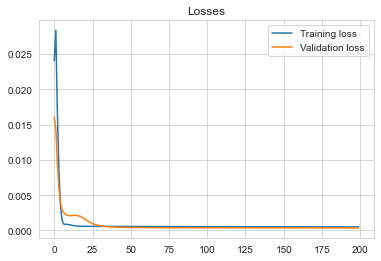

In [175]:

RNN_model = get_model('rnn', model_params)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(RNN_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
RNN_trainer = RnnTrainer(model=RNN_model, loss_fn=loss_fn, optimizer=optimizer,n_history=n_history)
RNN_trainer.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
RNN_trainer.plot_losses()

[200/200] Training loss: 0.0004	 Validation loss: 0.0003: 100%|██████████| 200/200 [01:00<00:00,  3.31it/s]


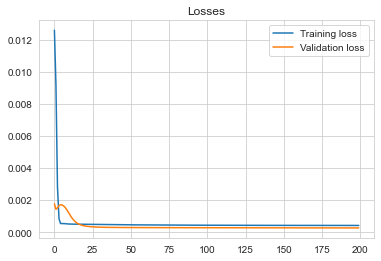

In [176]:

LSTM_model = get_model('lstm', model_params)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(LSTM_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
LSTM_trainer = RnnTrainer(model=LSTM_model, loss_fn=loss_fn, optimizer=optimizer,n_history=n_history)
LSTM_trainer.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
LSTM_trainer.plot_losses()

[200/200] Training loss: 0.0004	 Validation loss: 0.0003: 100%|██████████| 200/200 [01:03<00:00,  3.13it/s]


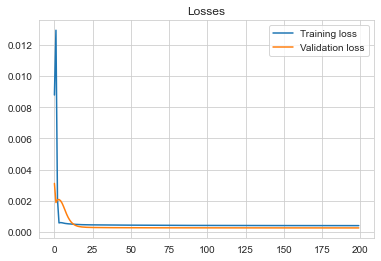

In [177]:

GRU_model = get_model('gru', model_params)
loss_fn = nn.MSELoss(reduction="mean")
optimizer = optim.Adam(GRU_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
GRU_trainer = RnnTrainer(model=GRU_model, loss_fn=loss_fn, optimizer=optimizer,n_history=n_history)
GRU_trainer.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
GRU_trainer.plot_losses()

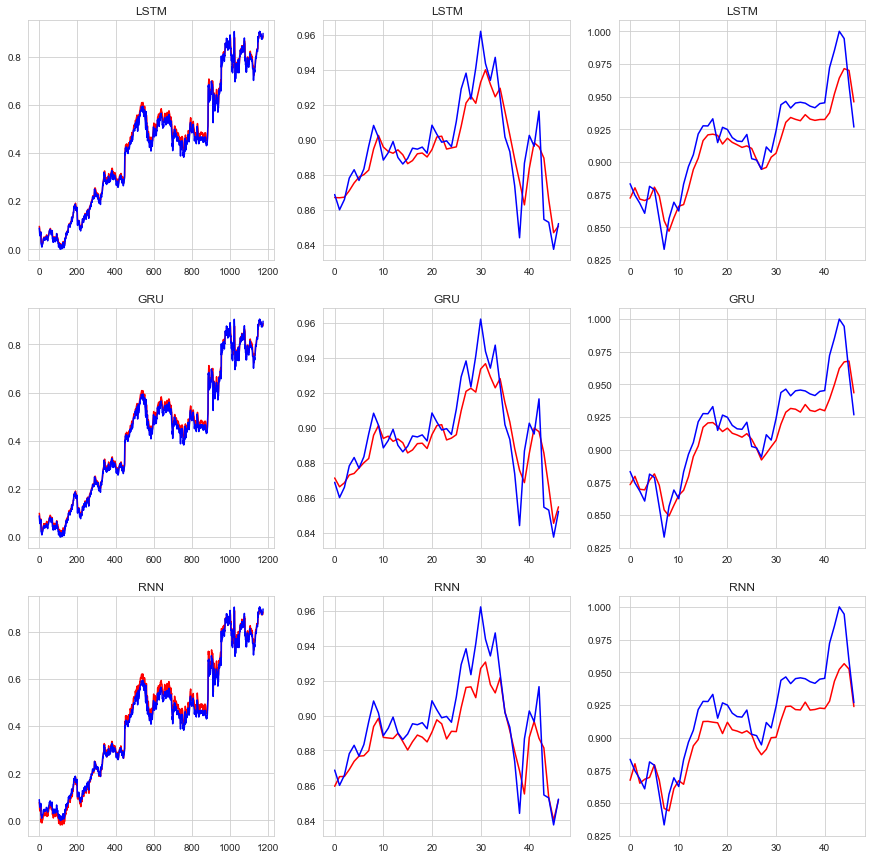

In [178]:
fig,ax=plt.subplots(3,3,figsize=(15,15))

ax[0][0].plot(LSTM_model(X_train.view((-1,3,n_history))).detach().numpy(),color='r')
ax[0][0].plot(y_train.numpy(),color='b')
ax[0][0].set(title='LSTM')

ax[1][0].plot(GRU_model(X_train.view((-1,3,n_history))).detach().numpy(),color='r')
ax[1][0].plot(y_train.numpy(),color='b')
ax[1][0].set(title='GRU')

ax[2][0].plot(RNN_model(X_train.view((-1,3,n_history))).detach().numpy(),color='r')
ax[2][0].plot(y_train.numpy(),color='b')
ax[2][0].set(title='RNN')



ax[0][1].plot(LSTM_model(X_val.view((-1,3,n_history))).detach().numpy(),color='r')
ax[0][1].plot(y_val.numpy(),color='b')
ax[0][1].set(title='LSTM')

ax[1][1].plot(GRU_model(X_val.view((-1,3,n_history))).detach().numpy(),color='r')
ax[1][1].plot(y_val.numpy(),color='b')
ax[1][1].set(title='GRU')

ax[2][1].plot(RNN_model(X_val.view((-1,3,n_history))).detach().numpy(),color='r')
ax[2][1].plot(y_val.numpy(),color='b')
ax[2][1].set(title='RNN')


ax[0][2].plot(LSTM_model(X_test.view((-1,3,n_history))).detach().numpy(),color='r')
ax[0][2].plot(y_test.numpy(),color='b')
ax[0][2].set(title='LSTM')

ax[1][2].plot(GRU_model(X_test.view((-1,3,n_history))).detach().numpy(),color='r')
ax[1][2].plot(y_test.numpy(),color='b')
ax[1][2].set(title='GRU')

ax[2][2].plot(RNN_model(X_test.view((-1,3,n_history))).detach().numpy(),color='r')
ax[2][2].plot(y_test.numpy(),color='b')
ax[2][2].set(title='RNN')

display()

In [179]:
LSTM_trainer.score(test_loader_one,single_scaler)

{'mae': 6.8263745,
 'mape ': 0.00856326,
 'rmse': 8.23437777958919,
 'r2': 0.8408882608267794}

In [180]:
RNN_trainer.score(test_loader_one,single_scaler)

{'mae': 9.293975,
 'mape ': 0.011611371,
 'rmse': 11.086953931777275,
 'r2': 0.7115536140637975}

In [181]:
GRU_trainer.score(test_loader_one,single_scaler)

{'mae': 6.922489,
 'mape ': 0.0086668385,
 'rmse': 8.381017544315547,
 'r2': 0.8351708033105173}